In [1]:
%env CUDA_LAUNCH_BLOCKING=1
import numpy as np
import torch
from ADEN import ADEN
from torchinfo import summary
from TestCaseGenerator import data_RLClustering
from ADENTrain import TrainAnneal
import utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
utils.set_seed(0)

env: CUDA_LAUNCH_BLOCKING=1
Using device: cuda
[Seed fixed to 0]


# Loading Data

In [2]:
# # FOR SYNTHETIC DATA
# X, M, T_P, N, d = data_RLClustering(4)
# X = torch.tensor(X).float().to(device)
# Y = torch.mean(X, dim=0, keepdim=True).to(device) + 0.01 * torch.randn(M, d).to(device)
# scenario_name = f"IDX4_M{M}"

In [3]:
# FOR DECENTRALIZED SENSING DATA
import scipy
address = f"MATLAB Codes/UTD19_London.mat"
# read as numpy array
data = scipy.io.loadmat(address)
locs = data['Xz']
# normalize locs to be in [0,1]x[0,1]
locs = (locs - np.min(locs, axis=0)) / (np.max(locs, axis=0) - np.min(locs, axis=0))
X = torch.tensor(locs).float().to(device)
N, d = X.shape
M = 50
Y = torch.mean(X, dim=0, keepdim=True).to(device) + 0.01 * torch.randn(M, d).to(device)
T_P = 0.0
scenario_name = f"UDT_M{M}"

# Creating Environment

In [4]:
eps = 0.4
gamma = 0.0
zeta = 1.0
T = 0.01
parametrized = True
from Env import ClusteringEnvTorch

env = ClusteringEnvTorch(
    n_data=N,
    n_clusters=M,
    n_features=d,
    parametrized=parametrized,
    eps=eps,
    gamma=gamma,
    zeta=zeta,
    T=T,
    T_p=torch.tensor(T_P),
    device=device,
)
scenario_name += f"eps{eps}gam{gamma}zet{zeta}T{T}"

# Loading ADEN Model

In [5]:

INPUT_DIM = d  # dimensionality of the input space
D_MODEL = 64  # dimensionality of the model
N_LAYERS = 4  # number of layers
N_HEADS = 8  # number of attention heads
D_FF = 128  # dimensionality of the feedforward network
DROPOUT = 0.01  # dropout rate

model = ADEN(
    input_dim=INPUT_DIM,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_ff=D_FF,
    dropout=DROPOUT,
    device=device
)

print(summary(model))
scenario_name += f"D{D_MODEL}_L{N_LAYERS}_H{N_HEADS}_FF{D_FF}_DO{DROPOUT}_"

Layer (type:depth-idx)                             Param #
ADEN                                               --
├─Linear: 1-1                                      192
├─Linear: 1-2                                      192
├─ModuleList: 1-3                                  --
│    └─AdaptiveDistanceBlock: 2-1                  --
│    │    └─MultiHeadDistanceAttention: 3-1        16,448
│    │    └─LayerNorm: 3-2                         128
│    │    └─LayerNorm: 3-3                         128
│    │    └─Sequential: 3-4                        16,576
│    │    └─Dropout: 3-5                           --
│    └─AdaptiveDistanceBlock: 2-2                  --
│    │    └─MultiHeadDistanceAttention: 3-6        16,448
│    │    └─LayerNorm: 3-7                         128
│    │    └─LayerNorm: 3-8                         128
│    │    └─Sequential: 3-9                        16,576
│    │    └─Dropout: 3-10                          --
│    └─AdaptiveDistanceBlock: 2-3                  --
│

# Main Annealing Loop

In [6]:

# writing all hyperparameters in one place
EPOCHS_DBAR = 1000
BATCH_SIZE_DBAR = 32
NUM_SAMPLES_IN_BATCH_DBAR = 128
LR_DBAR = 1e-4
WEIGHT_DECAY_DBAR = 1e-5
TOL_TRAIN_DBAR = 1e-6
PROBS_DBAR = torch.tensor(T_P)

EPOCHS_TRAIN_Y = 100 
BATCH_SIZE_TRAIN_Y = None
LR_TRAIN_Y = 1e-4 
WEIGHT_DECAY_TRAIN_Y = 1e-5
TOL_TRAIN_Y = 1e-4

BETA_INIT = 10.0
BETA_F = 10000.0
BETA_GROWTH_RATE = 1.1 
PERTURBATION_STD = 0.01 



Y_opt, pi, history_y_all, history_pi_all , Betas = TrainAnneal(
    model,
    X,
    Y,
    env,
    device,
    # TrainDbar hyperparameters
    epochs_dbar=EPOCHS_DBAR,
    batch_size_dbar=BATCH_SIZE_DBAR,
    num_samples_in_batch_dbar=NUM_SAMPLES_IN_BATCH_DBAR,
    lr_dbar=LR_DBAR,
    weight_decay_dbar=WEIGHT_DECAY_DBAR,
    tol_train_dbar=TOL_TRAIN_DBAR,
    # trainY hyperparameters
    epochs_train_y=EPOCHS_TRAIN_Y,
    batch_size_train_y=BATCH_SIZE_TRAIN_Y,
    lr_train_y=LR_TRAIN_Y,
    weight_decay_train_y=WEIGHT_DECAY_TRAIN_Y,
    tol_train_y=TOL_TRAIN_Y,
    # annealing schedule
    beta_init=BETA_INIT,
    beta_final=BETA_F,
    beta_growth_rate=BETA_GROWTH_RATE,
    perturbation_std=PERTURBATION_STD,
)
scenario_name += f"EpD{EPOCHS_DBAR}BSD{BATCH_SIZE_DBAR}NSD{NUM_SAMPLES_IN_BATCH_DBAR}LRD{LR_DBAR}"
scenario_name += f"EpY{EPOCHS_TRAIN_Y}LRY{LR_TRAIN_Y}"
scenario_name += f"_{BETA_INIT}to{BETA_F}rate{BETA_GROWTH_RATE}_Pert{PERTURBATION_STD}"


=== Annealing step: Beta = 1.000e+01 ===
[TrainDbar_Hybrid_vec] Epoch 0, MSE Loss: 2.488e+01
[TrainDbar_Hybrid_vec] Epoch 1000, MSE Loss: 5.449e-01
[trainY] Epoch 0, F: -3.209e-01
[trainY] Converged at epoch 1, F: -3.209e-01

=== Annealing step: Beta = 1.100e+01 ===
[TrainDbar_Hybrid_vec] Epoch 0, MSE Loss: 5.618e-01
[TrainDbar_Hybrid_vec] Epoch 1000, MSE Loss: 1.847e-01
[trainY] Epoch 0, F: -2.894e-01
[trainY] Converged at epoch 1, F: -2.894e-01

=== Annealing step: Beta = 1.210e+01 ===
[TrainDbar_Hybrid_vec] Epoch 0, MSE Loss: 2.549e-01
[TrainDbar_Hybrid_vec] Epoch 1000, MSE Loss: 1.000e-01
[trainY] Epoch 0, F: -2.575e-01
[trainY] Converged at epoch 1, F: -2.575e-01

=== Annealing step: Beta = 1.331e+01 ===
[TrainDbar_Hybrid_vec] Epoch 0, MSE Loss: 1.700e-01
[TrainDbar_Hybrid_vec] Epoch 1000, MSE Loss: 6.713e-02
[trainY] Epoch 0, F: -2.286e-01
[trainY] Converged at epoch 1, F: -2.286e-01

=== Annealing step: Beta = 1.464e+01 ===
[TrainDbar_Hybrid_vec] Epoch 0, MSE Loss: 1.348e-01
[T

UDT_M50eps0.4gam0.0zet1.0T0.01D64_L4_H8_FF128_DO0.01_EpD1000BSD32NSD128LRD0.0001EpY100LRY0.0001_10.0to10000.0rate1.1_Pert0.01


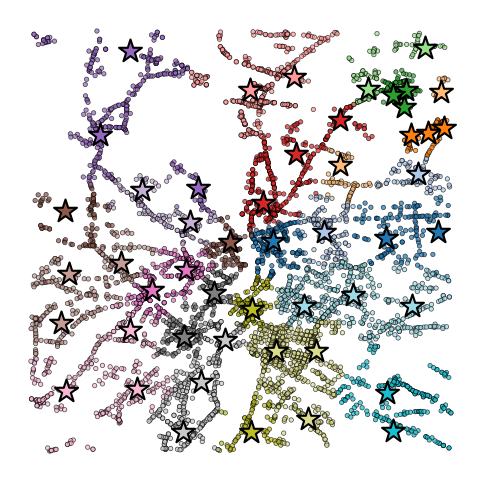

In [7]:

from Plotter import PlotClustering


X_np = X.detach().cpu().numpy()
y_np = Y_opt.detach().cpu().numpy()
print(scenario_name)
PlotClustering(X_np, y_np, pi, figsize = (12,6),cmap='tab20',point_size=10)

# Save the Results

In [8]:
import pickle



save_dict = {
    "N": N,
    "M": M,
    "d": d,
    # Hyperparameters
    "EPOCHS_DBAR": EPOCHS_DBAR,
    "BATCH_SIZE_DBAR": BATCH_SIZE_DBAR,
    "NUM_SAMPLES_IN_BATCH_DBAR": NUM_SAMPLES_IN_BATCH_DBAR,
    "LR_DBAR": LR_DBAR,
    "WEIGHT_DECAY_DBAR": WEIGHT_DECAY_DBAR,
    "TOL_TRAIN_DBAR": TOL_TRAIN_DBAR,
    "PROBS_DBAR": PROBS_DBAR,
    "EPOCHS_TRAIN_Y": EPOCHS_TRAIN_Y,
    "BATCH_SIZE_TRAIN_Y": BATCH_SIZE_TRAIN_Y,
    "LR_TRAIN_Y": LR_TRAIN_Y,
    "WEIGHT_DECAY_TRAIN_Y": WEIGHT_DECAY_TRAIN_Y,
    "TOL_TRAIN_Y": TOL_TRAIN_Y,
    "BETA_INIT": BETA_INIT,
    "BETA_F": BETA_F,
    "BETA_GROWTH_RATE": BETA_GROWTH_RATE,
    "PERTURBATION_STD": PERTURBATION_STD,
    # Results
    "X": X,
    "Y_opt": Y_opt,
    "history_y_all": history_y_all,
    "history_pi_all": history_pi_all,
    # Model architecture
    "INPUT_DIM": INPUT_DIM,
    "D_MODEL": D_MODEL,
    "N_LAYERS": N_LAYERS,
    "N_HEADS": N_HEADS,
    "D_FF": D_FF,
    "DROPOUT": DROPOUT
}

with open(f"Results/{scenario_name}.pkl", "wb") as f:
    pickle.dump(save_dict, f)



# Load the Results

In [9]:
# import pickle
# # Now craete a load function to load the results
# def load_results(scenario_name):
#     with open(f"Results/{scenario_name}_results.pkl", "rb") as f:
#         data = pickle.load(f)
#     return data
# results = load_results(scenario_name)
# X = results["X"]
# Y_opt = results["Y_opt"]
# history_y_all = results["history_y_all"]
# history_pi_all = results["history_pi_all"]

In [10]:
from animator import animate_Clusters
# history_pi_all[0] = history_pi_all[1]
animate_Clusters(
    X.detach().cpu().numpy(),
    history_y_all,
    history_pi_all,
    Betas,
    interval=250,
    save_path=f"Results/{scenario_name}.gif",
)